In [1]:
%matplotlib notebook

import IPython.display
import tensorflow as tf
import PIL
import subprocess
import sys

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
s = tf.Session()

In [3]:
n = 8

In [4]:
rnd_gen = tf.random_uniform((n, 3), dtype=tf.float64)

In [5]:
y = tf.Variable(rnd_gen, dtype=tf.float64, trainable=True)

In [6]:
yyt = tf.matmul(y, tf.transpose(y))
sqlen = tf.matrix_diag_part(yyt)
trp = tf.tile(tf.reshape(sqlen, [1, -1]), [n, 1])
trq = tf.tile(tf.reshape(sqlen, [-1, 1]), [1, n])
qlenbetween = -yyt * 2 + trq + trp + tf.eye(n, dtype=tf.float64)
potentials = 1 / tf.sqrt(qlenbetween) - tf.eye(n, dtype=tf.float64)
global_potent = tf.reduce_sum(potentials) + 10 * tf.norm(sqlen - tf.fill((n,), tf.constant(1, dtype=tf.float64)), ord=2)

In [7]:
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(0.05, global_step, 20, 0.9, staircase=True)

In [8]:
s.run(tf.global_variables_initializer())

In [9]:
s.run(global_potent)

101.57904198831017

In [10]:
!! rm imgs/*.png

[]

In [11]:
meter = 0
angle = 0

In [12]:
g_o = tf.train.GradientDescentOptimizer(learning_rate)
step = g_o.minimize(global_potent, global_step)

'iteration 200 done. l_r = 1.3280664461490232e-06 global_potent = 39.351297265905295 diff = 0.00011432347715611968'

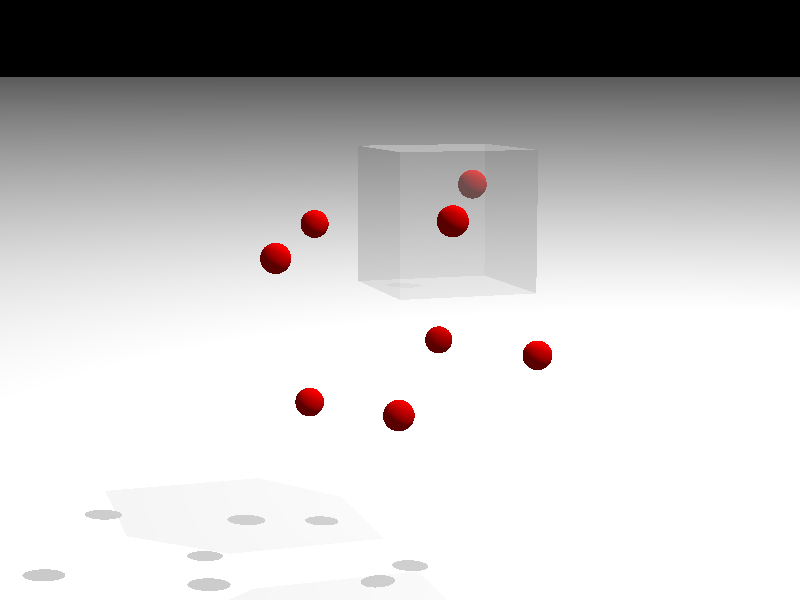

In [13]:
for iter_num in range(200):
    angle += 0.5
    prev = s.run(global_potent)
    for _ in range(10):
        s.run(step)
    current = s.run(global_potent)
    data = s.run([y])[0]
    h, w = data.shape
    with open('points.pov', 'w') as dst:
        for p in range(h):
            xx = data[p][0]
            yy = data[p][1]
            zz = data[p][2]
            print('sphere {{< {}, {}, {}> .1 pigment {{color<1,0,0>}}}}'.format(xx, yy, zz), file=dst)
   
    with open('cam_angle.pov', 'w') as dst:
        angle_def = '#declare cam_angle = {};\n'.format(0.70 + angle/100)
        dst.write(angle_def)
    out_flnm = 'imgs/img_{:04}.png'.format(meter)
    povray_process = subprocess.Popen(['povray', 'cube.pov', '-O'+out_flnm, '-D0'],
                                     stderr=subprocess.PIPE,
                                     stdout=subprocess.PIPE)
    err_code = povray_process.communicate()
    if povray_process.returncode:
        print(err_code[1].decode('utf-8'))
        break
    meter += 1
    IPython.display.clear_output()
    IPython.display.display(
        'iteration {} done. l_r = {} global_potent = {} diff = {}'
        .format(meter, s.run(learning_rate), current, current - prev))
    IPython.display.display(PIL.Image.open(out_flnm))    

In [ ]:
s.run(y)

In [ ]:
s.run(tf.matmul(y, tf.transpose(y)))

In [ ]:
s.run(yyt)

In [ ]:
s.run(global_potent)

In [ ]:
data = s.run([y])[0]

plt.figure(figsize=(10, 10))
ax=plt.axes(projection='3d')
ax.view_init(10,45)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
xx=data[:, 0]
yy=data[:, 1]
zz=data[:, 2]
dx=max(xx)-min(xx)
dy=max(yy)-min(yy)
dz=max(zz)-min(zz)
dcommon = max(dx, dy, dz)
mx = (max(xx)+min(xx))/2
my = (max(yy)+min(yy))/2
mz = (max(zz)+min(zz))/2
ax.set_xlim3d((mx-dcommon/2,mx+dcommon/2))
ax.set_ylim3d((my-dcommon/2,my+dcommon/2))
ax.set_zlim3d((mz-dcommon/2,mz+dcommon/2))
ax.scatter(xx,yy,zz)
plt.show()

In [ ]:
g_o = tf.train.AdamOptimizer()
step = g_o.minimize(global_potent)

In [ ]:
g_o = tf.train.MomentumOptimizer(0.000001, 0.3)
step = g_o.minimize(global_potent)

In [ ]:
prev = s.run(global_potent)
for _ in range(100):
    s.run([step])
current = s.run(global_potent)
'{} -> {} with diff {}'.format(prev, current, current - prev)